Installing the spectral library for reading the **.qub** and **.hdr** files

In [139]:
! pip install spectral
import os
import spectral
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten , MaxPooling2D

Mount the Gdrive

In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Specifying the files path to variables

In [141]:
data_file = "/content/drive/MyDrive/IIRS/hyperspectral_image.qub"
header_file = "/content/drive/MyDrive/IIRS/image_metadata.hdr"
geometry_file = "/content/drive/MyDrive/IIRS/geolocation_data.csv"

Reading the data

In [142]:
data = spectral.io.envi.open(header_file, image=data_file)
hyperspectral_data = data.load()
print(f"Shape of the data: {hyperspectral_data.shape}")

Saving the plots using custom `save_fig()` function

In [98]:
IMAGES_PATH = Path() / "images" / "hyperspectral"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Plot of reflectance variation
The `plot_reflectance_variation(x, y)` below plots the reflectance values with respect to the wavelength at the coordinates specified by the user.
*Coordinates must be in the range of (250 , 9340)*

In [99]:
def plot_reflectance_variation(x , y):
  if x >= 0 and x < hyperspectral_data.shape[1] and y >= 0 and y < hyperspectral_data.shape[0]:
    reflectance_values = hyperspectral_data[y, x, :]
    plt.figure(figsize = (10 , 6))
    plt.plot(range(hyperspectral_data.shape[2]), reflectance_values.squeeze())
    plt.xlabel('Wavelength')
    plt.ylabel('Reflectance')
    plt.title(f'Reflectance Variation at ({x}, {y})')
    save_fig("reflectance variation vs wavelength")
    plt.show()
  else:
    print("Invalid coordinates")

Enter the x coordinate: 10
Enter the y coordinate: 12


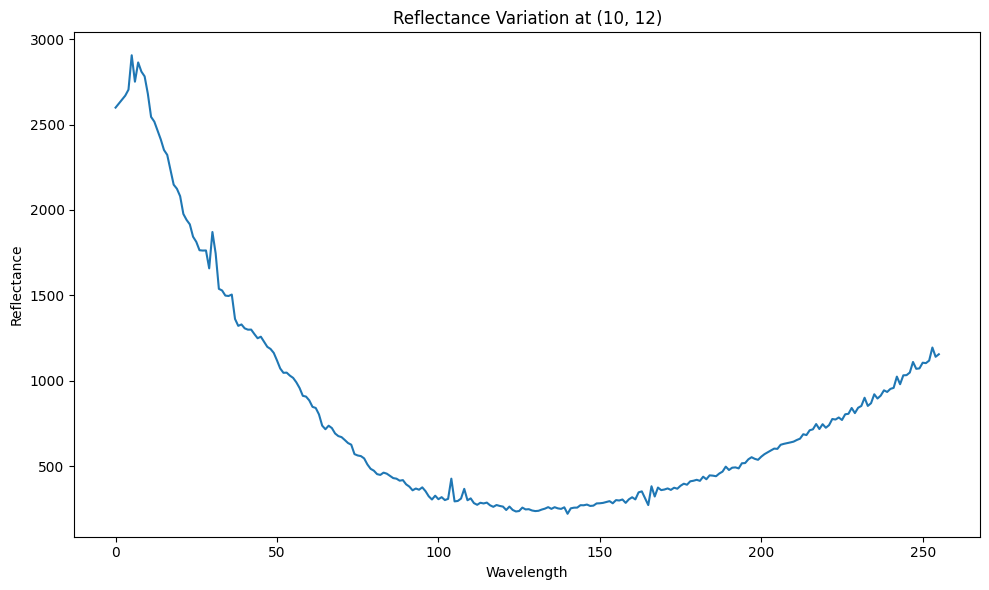

In [100]:
x = int(input("Enter the x coordinate: "))
y = int(input("Enter the y coordinate: "))
plot_reflectance_variation(x , y)

Plotting the grayscale image of the 9340 x 250 region at 6 different wavelength (bands -  10 , 50 , 100 , 150 , 200 , 256)

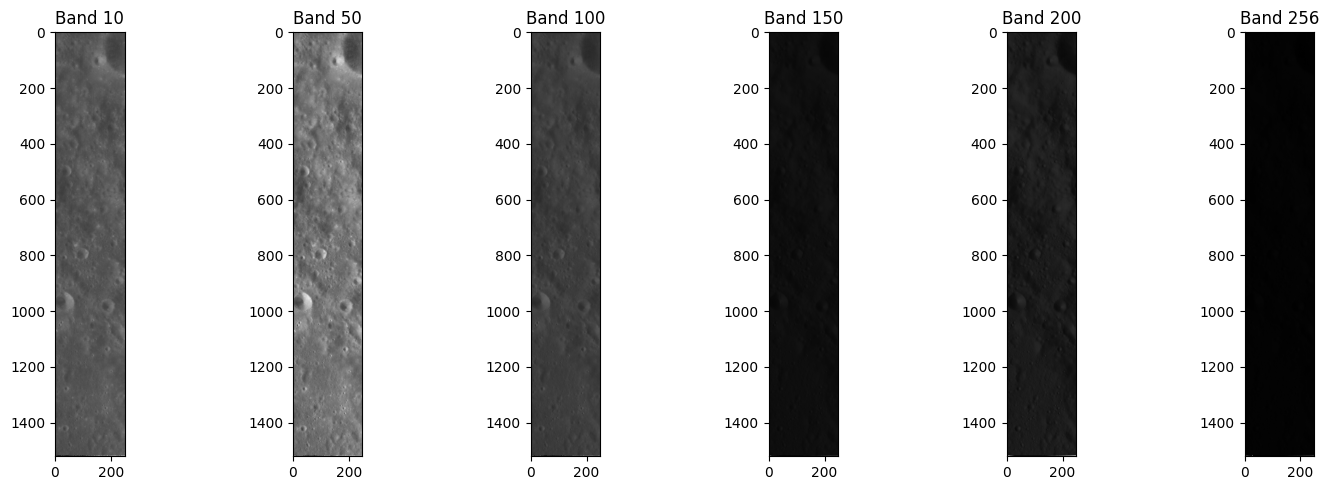

In [101]:
fig, axes = plt.subplots(1, 6, figsize=(15, 5))

axes[0].imshow(hyperspectral_data[:,:,10], cmap='gray')
axes[0].set_title('Band 10')

axes[1].imshow(hyperspectral_data[:,:,50], cmap='gray')
axes[1].set_title('Band 50')

axes[2].imshow(hyperspectral_data[:,:,100], cmap='gray')
axes[2].set_title('Band 100')

axes[3].imshow(hyperspectral_data[:,:,150], cmap='gray')
axes[3].set_title('Band 150')

axes[4].imshow(hyperspectral_data[:,:,200], cmap='gray')
axes[4].set_title('Band 200')

axes[5].imshow(hyperspectral_data[:,:,255], cmap='gray')
axes[5].set_title('Band 256')

save_fig("grayscale image of strip at 6 different bands")

plt.show()

# Plot of moon surface with region of interest along with geographical coordinates at a specific band

In [102]:
coord_df = pd.read_csv(geometry_file)

In [103]:
coord_df.head()

,Longitude,Latitude,Pixel,Scan
0,146.275991,12.350115,0,0
1,146.418392,12.347578,50,0
2,146.560712,12.344941,100,0
3,146.702993,12.342201,150,0
4,146.845278,12.339360,200,0


Enter the band: 55


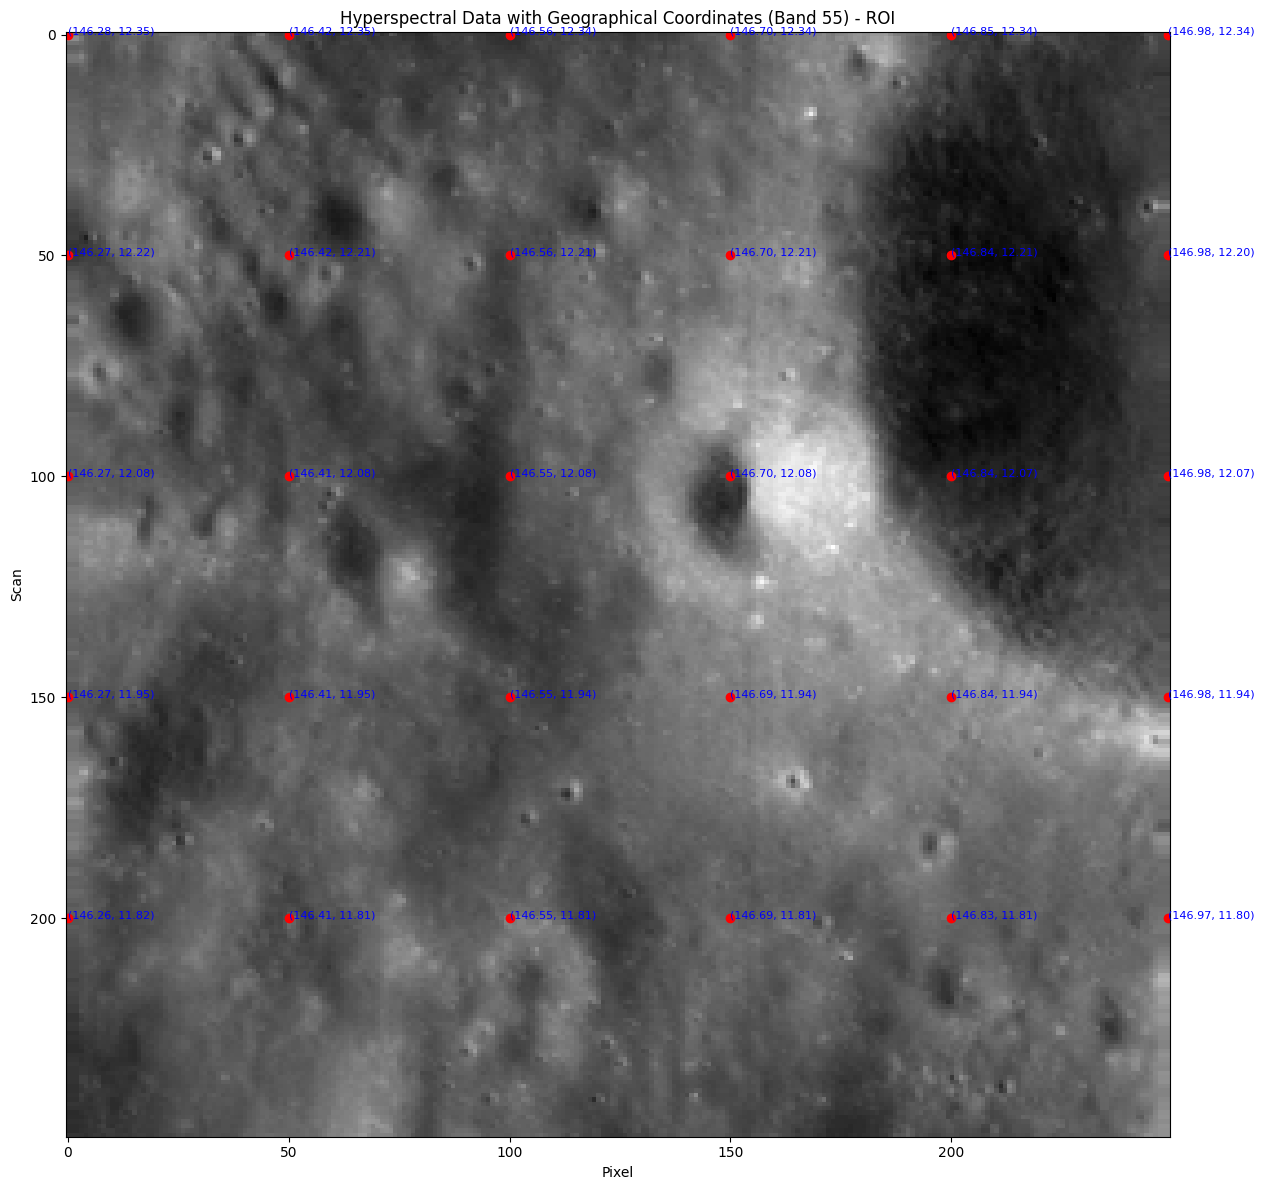

In [104]:
# roi = region of interest
roi_start_x = 0
roi_end_x = 250
roi_start_y = 0
roi_end_y = 250

def plot_roi_hyperspectral_with_coords(band_index):
    plt.figure(figsize=(20, 12))

    plt.imshow(hyperspectral_data[roi_start_y:roi_end_y, roi_start_x:roi_end_x, band_index], cmap='gray')

    for index, row in coord_df.iterrows():
        pixel = row['Pixel']
        scan = row['Scan']


        if roi_start_x <= pixel < roi_end_x and roi_start_y <= scan < roi_end_y:
            lon = row['Longitude']
            lat = row['Latitude']


            plt.plot(pixel - roi_start_x, scan - roi_start_y, 'ro')
            plt.text(pixel - roi_start_x, scan - roi_start_y, f"({lon:.2f}, {lat:.2f})", color='blue', fontsize=8)

    plt.title(f'Hyperspectral Data with Geographical Coordinates (Band {band_index}) - ROI')
    plt.xlabel('Pixel')
    plt.ylabel('Scan')
    save_fig(f"Image geographical coordinates")
    plt.show()

plot_roi_hyperspectral_with_coords(int(input(f"Enter the band: ")))

# Data Preparation
* Reshaping
* Normalization
* PCA

Normalizing the data by dividing each reflectance value by the maximum reflectance value . In order to achieve values between 0-1. This will improve the traning time of the ml models.

In [105]:
normalized_data = hyperspectral_data / np.max(hyperspectral_data)

<ipython-input-105-f26c69d4375b>:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  normalized_data = hyperspectral_data / np.max(hyperspectral_data)


Reducing the dimention of the data to 2-dimentions

In [106]:
flattened_data = normalized_data.reshape(-1, normalized_data.shape[-1])

In [107]:
flattened_data.shape

(380250, 256)

In [108]:
print(flattened_data[:10])

[[0.00622076 0.00667409 0.00712743 ... 0.00308375 0.00287057 0.00295244]
 [0.00622076 0.00667409 0.00712743 ... 0.00308375 0.00287057 0.00295244]
 [0.00622076 0.00667409 0.00712743 ... 0.00308375 0.00287057 0.00295244]
 ...
 [0.00576955 0.00585054 0.00593153 ... 0.00332213 0.00325173 0.00342796]
 [0.00444085 0.0047199  0.00499894 ... 0.00339197 0.00298064 0.00302577]
 [0.0038356  0.00437755 0.0049195  ... 0.00350411 0.00310666 0.00323648]]


# Dimensionality Reduction using Principal component analysis

* PCA can further reduce the dimensionality by keeping the most important components, making it more manageable for clustering and CNN processing.
* As you can see the 10 principal components capture 98.31% of the variability in your original hyperspectral data

In [109]:
pca = PCA(n_components = 10)
reduces_data = pca.fit_transform(flattened_data)

explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained Variance Ratio by 10 components: {explained_variance}")

Explained Variance Ratio by 10 components: 0.959985077381134


In [110]:
reduces_data.shape

(380250, 10)

# Clustering

* Applying **k-mean clustering**

Applying k-mean to seperate the data into 5 different clusters . We will use these clusters as labels for classification.

In [111]:
kmean = KMeans(n_clusters=5)

In [112]:
labels = kmean.fit_predict(reduces_data)

In [113]:
def nearest_centroid(X , centroid):
  k = centroid.shape[0]
  c = np.zeros(X.shape[0] , dtype=int)

  for i in range(X.shape[0]):
    distance = []
    for j in range(k):
      norm_ij = np.linalg.norm(X[i] - centroid[j])
      distance.append(norm_ij)
    c[i] = np.argmin(distance)
  return c

def compute_centroid(X , c , k):
  m , n = X.shape
  centroids = np.zeros((k , n))
  for i in range(k):
    centroids[i] = np.mean(X[c == i] , axis = 0)
  return centroids

def initialize_centroid(X , k):
  random_index = np.random.permutation(X.shape[0])
  return X[random_index[:k]]

In [114]:
def run_kMeans(X, initial_centroids, iter, plot_progress=False):
    m, n = X.shape
    k = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids
    idx = np.zeros(m)
    plt.figure(figsize=(8, 6))


    for i in range(iter):
        print("K-Means iteration %d/%d" % (i, iter-1))
        idx = nearest_centroid(X, centroids)
        if plot_progress:
            # plot_progress_kMeans(X, centroids, previous_centroids, idx, k, i)
            previous_centroids = centroids
        centroids = compute_centroid(X, idx, k)
    plt.show()
    return centroids, idx

In [115]:

k = 5
iter = 4
initial_centroids = initialize_centroid(reduces_data , k)
centroids , c = run_kMeans(reduces_data , initial_centroids , iter )

K-Means iteration 0/3
K-Means iteration 1/3
K-Means iteration 2/3
K-Means iteration 3/3


<Figure size 800x600 with 0 Axes>

In [116]:
centroids , c.shape , centroids.shape

(array([[-3.87015264e-03,  1.64575264e-04,  6.24316686e-04,
          1.18745993e-04, -4.20649376e-05,  2.19795038e-05,
         -1.96081219e-05, -1.09923922e-05,  3.36669764e-05,
         -1.93210088e-08],
        [-4.37471503e-03,  5.66269178e-03, -2.87757575e-04,
          3.71710834e-04,  8.27073090e-05,  1.02188264e-04,
         -1.36424307e-04,  1.59427858e-04,  2.16530694e-04,
          9.80053082e-05],
        [ 3.64734791e-03,  3.31699639e-03, -7.45076686e-04,
          3.87082328e-05,  5.31008118e-05,  5.79705602e-06,
         -1.21479807e-05,  6.51371829e-06, -1.45697659e-05,
          2.25726344e-05],
        [ 5.62277623e-03, -5.32671669e-03, -1.24909473e-03,
         -3.03240871e-04,  7.05255079e-05, -5.77032297e-05,
          4.63709475e-05, -1.68865574e-06, -8.11276768e-05,
         -7.81505878e-06],
        [ 4.28224856e-04, -8.73685000e-04,  4.72679705e-04,
         -8.80336665e-05, -4.93129228e-05, -2.69742723e-05,
          4.42931705e-05, -5.07251061e-05, -5.831682

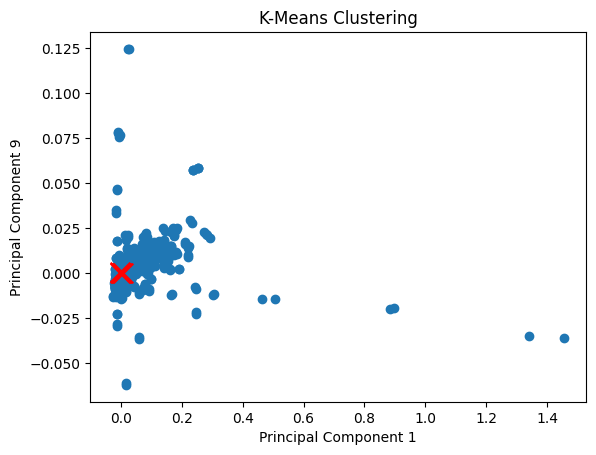

In [117]:
plt.scatter(reduces_data[:, 0], reduces_data[:, 8])
plt.scatter(centroids[:, 0], centroids[:, 8], marker='x', color='red', s=200)
plt.title("K-Means Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 9")
plt.show()

In [118]:
clustered_image = labels.reshape(hyperspectral_data.shape[0] , hyperspectral_data.shape[1])

In [119]:
labels.shape

(380250,)

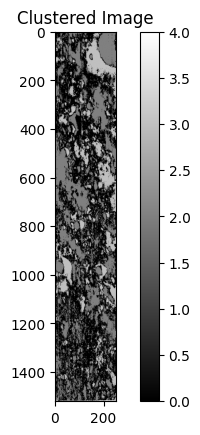

In [120]:
plt.imshow(clustered_image, cmap='gray')
plt.title("Clustered Image")
plt.colorbar()
plt.show()

# Classification
* CNN

Splitting the data into traning and test sets.

In [121]:
X = reduces_data
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
X_train.shape

(304200, 10)

* Defining the input shape of the data to the CNN Model.
* Then building the structure of the CNN model.

In [123]:
X_train_cnn = X_train.reshape(-1, 10, 1, 1)
X_test_cnn = X_test.reshape(-1, 10, 1, 1)

In [124]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(10 ,1,1) ,  padding='same'),
    MaxPooling2D((2, 1)),
    Conv2D(64, (3, 3), activation='relu',  padding='same'),
    MaxPooling2D((2, 1)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [125]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 10, 1, 32)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 1, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 1, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,325 (251.27 KB)

 Trainable params: 64,325 (251.27 KB)

 Non-trainable params: 0 (0.00 B)

Then compiling and fitting the model

In [126]:
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
7605/7605 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.7408 - loss: 0.5730 - val_accuracy: 0.9675 - val_loss: 0.0785
Epoch 2/10
7605/7605 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.9813 - loss: 0.0478 - val_accuracy: 0.9849 - val_loss: 0.0365
Epoch 3/10
7605/7605 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9847 - loss: 0.0367 - val_accuracy: 0.9813 - val_loss: 0.0438
Epoch 4/10
7605/7605 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9847 - loss: 0.0358 - val_accuracy: 0.9797 - val_loss: 0.0444
Epoch 5/10
7605/7605 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.9858 - loss: 0.0326 - val_accuracy: 0.9862 - val_loss: 0.0331
Epoch 6/10
7605/7605 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9869 - loss: 0.0302 - val_accuracy: 0.9846 - val_loss: 0.0354
Epoch 7/10
7605/7605 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.9879 - loss: 0.0276 - val_accuracy: 0.9893 - val_loss: 0.0270
Epoch 8/10
7605/7605 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9881 - loss: 0

In [127]:
cnn_eval = cnn_model.evaluate(X_test_cnn, y_test)
print(f'CNN Accuracy: {cnn_eval[1]}')

2377/2377 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9856 - loss: 0.0328
CNN Accuracy: 0.9844181537628174


ON TEST SET OUR MODEL IS GIVING ACCURACY OF MORE THAN 98%

In [128]:
# Reshape the full data for prediction
full_data_cnn = reduces_data.reshape(-1, 10, 1, 1)
predicted_classes = cnn_model.predict(full_data_cnn)
predicted_labels = np.argmax(predicted_classes, axis=1)

# Reshape back to image dimensions
classified_image = predicted_labels.reshape(hyperspectral_data.shape[0], hyperspectral_data.shape[1])

11883/11883 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


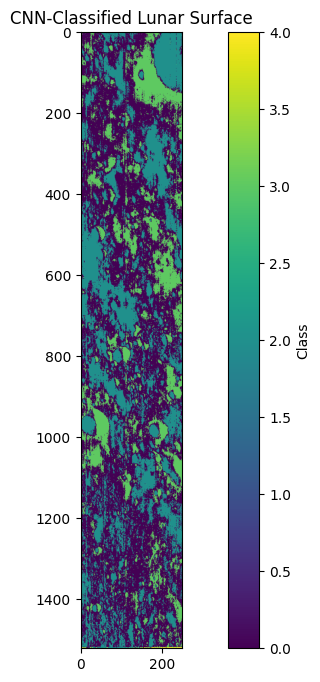

In [129]:
plt.figure(figsize=(12, 8))
plt.imshow(classified_image, cmap='viridis')
plt.title("CNN-Classified Lunar Surface")
plt.colorbar(label="Class")
plt.show()

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


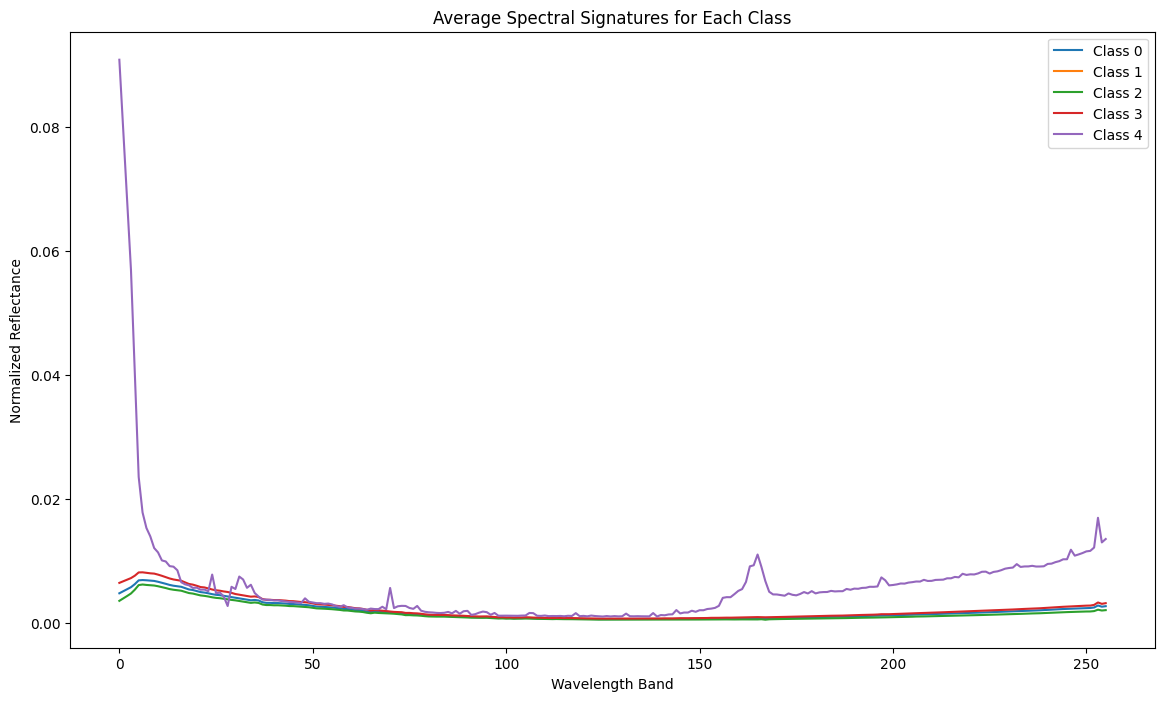

In [130]:
# Extract average spectra for each class
class_spectra = []
for i in range(5):
    class_mask = (predicted_labels == i)
    avg_spectrum = np.mean(flattened_data[class_mask], axis=0)
    class_spectra.append(avg_spectrum)

# Plot average spectra for each class
plt.figure(figsize=(14, 8))
for i, spectrum in enumerate(class_spectra):
    plt.plot(range(256), spectrum, label=f"Class {i}")
plt.title("Average Spectral Signatures for Each Class")
plt.xlabel("Wavelength Band")
plt.ylabel("Normalized Reflectance")
plt.legend()
plt.show()

In [131]:
# 1. Apply the trained CNN model to the entire dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd


In [132]:
# Reshape the full PCA-reduced data for prediction
print("Reshaping data for prediction...")
full_data_cnn = reduces_data.reshape(-1, 10, 1, 1)

# Generate predictions
print("Generating predictions with CNN model...")
predicted_probabilities = cnn_model.predict(full_data_cnn)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Reshape back to original image dimensions
classified_image = predicted_labels.reshape(hyperspectral_data.shape[0], hyperspectral_data.shape[1])


Reshaping data for prediction...
Generating predictions with CNN model...
11883/11883 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step


Visualizing the final classified lunar surface...


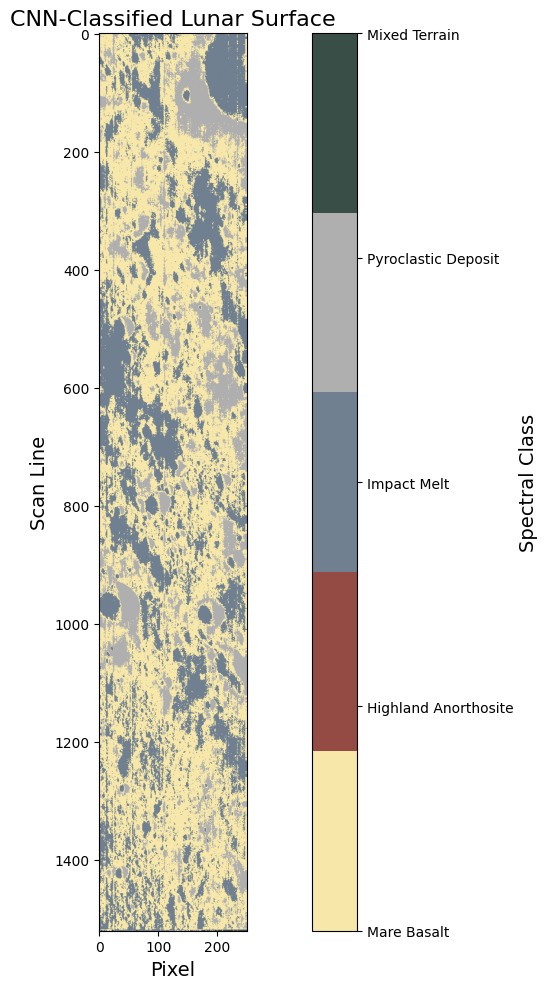

In [133]:
# 2. Visualize the final classified image
print("Visualizing the final classified lunar surface...")
lunar_cmap = ListedColormap(['#f7e8aa', '#934b43', '#708090', '#afafaf', '#3a4e48'])

plt.figure(figsize=(14, 10))
plt.imshow(classified_image, cmap=lunar_cmap)
plt.title("CNN-Classified Lunar Surface", fontsize=16)
cbar = plt.colorbar(ticks=range(5))
cbar.set_label("Spectral Class", fontsize=14)
cbar.set_ticklabels(['Mare Basalt', 'Highland Anorthosite', 'Impact Melt', 'Pyroclastic Deposit', 'Mixed Terrain'])
plt.xlabel("Pixel", fontsize=14)
plt.ylabel("Scan Line", fontsize=14)
save_fig("cnn_classified_lunar_surface")
plt.show()


In [134]:
# 3. Extract and analyze average spectral signatures for each class
print("Extracting spectral signatures for each class...")
class_spectra = []
class_names = ['Mare Basalt', 'Highland Anorthosite', 'Impact Melt', 'Pyroclastic Deposit', 'Mixed Terrain']
class_colors = ['#f7e8aa', '#934b43', '#708090', '#afafaf', '#3a4e48']

for i in range(5):
    class_mask = (predicted_labels == i)
    if np.any(class_mask):  # Check if there are any pixels with this class
        avg_spectrum = np.mean(flattened_data[class_mask], axis=0)
        class_spectra.append(avg_spectrum)
    else:
        print(f"Warning: No pixels found for Class {i}")
        class_spectra.append(np.zeros(flattened_data.shape[1]))


Extracting spectral signatures for each class...


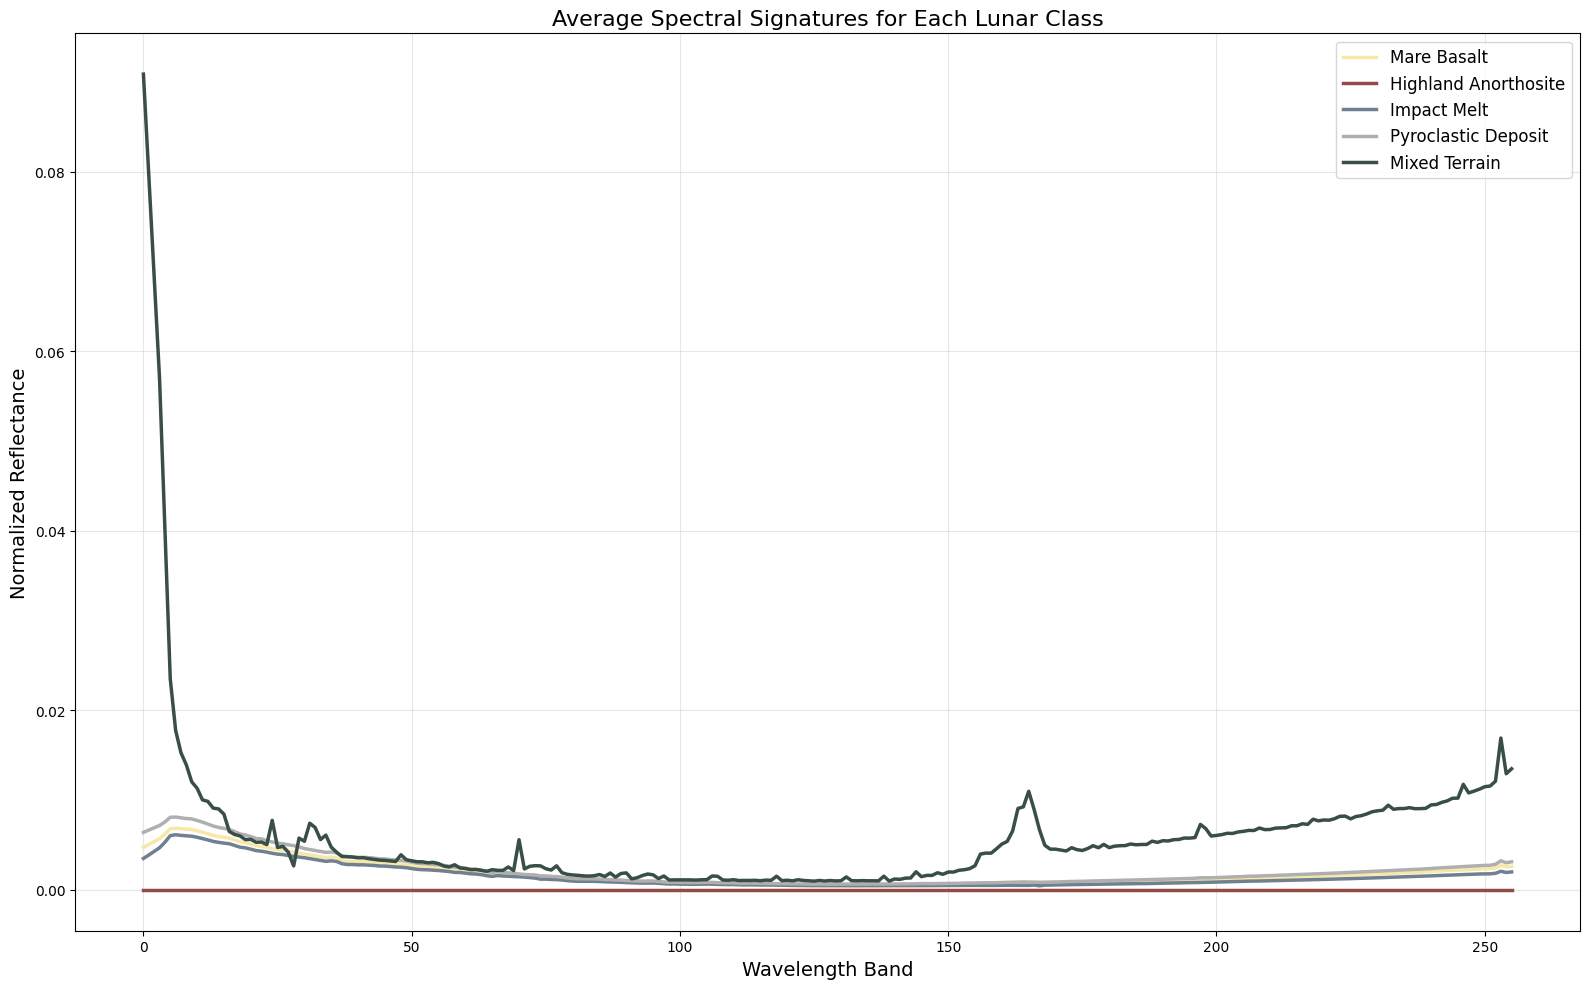

In [135]:

# 4. Plot average spectral signatures
plt.figure(figsize=(16, 10))
for i, spectrum in enumerate(class_spectra):
    plt.plot(range(hyperspectral_data.shape[2]), spectrum, label=class_names[i],
             linewidth=2.5, color=class_colors[i])

plt.title("Average Spectral Signatures for Each Lunar Class", fontsize=16)
plt.xlabel("Wavelength Band", fontsize=14)
plt.ylabel("Normalized Reflectance", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
save_fig("class_spectral_signatures")
plt.show()

In [136]:
# 5. Calculate class distribution
class_counts = np.bincount(predicted_labels, minlength=5)
class_percentages = class_counts / len(predicted_labels) * 100

# Create a DataFrame for better presentation
class_df = pd.DataFrame({
    'Class': class_names,
    'Count': class_counts,
    'Percentage': class_percentages
})

print("\nClass Distribution in the Classified Image:")
print(class_df)



Class Distribution in the Classified Image:
                  Class   Count  Percentage
0           Mare Basalt  203406   53.492702
1  Highland Anorthosite       0    0.000000
2           Impact Melt  112846   29.676792
3   Pyroclastic Deposit   63827   16.785536
4         Mixed Terrain     171    0.044970


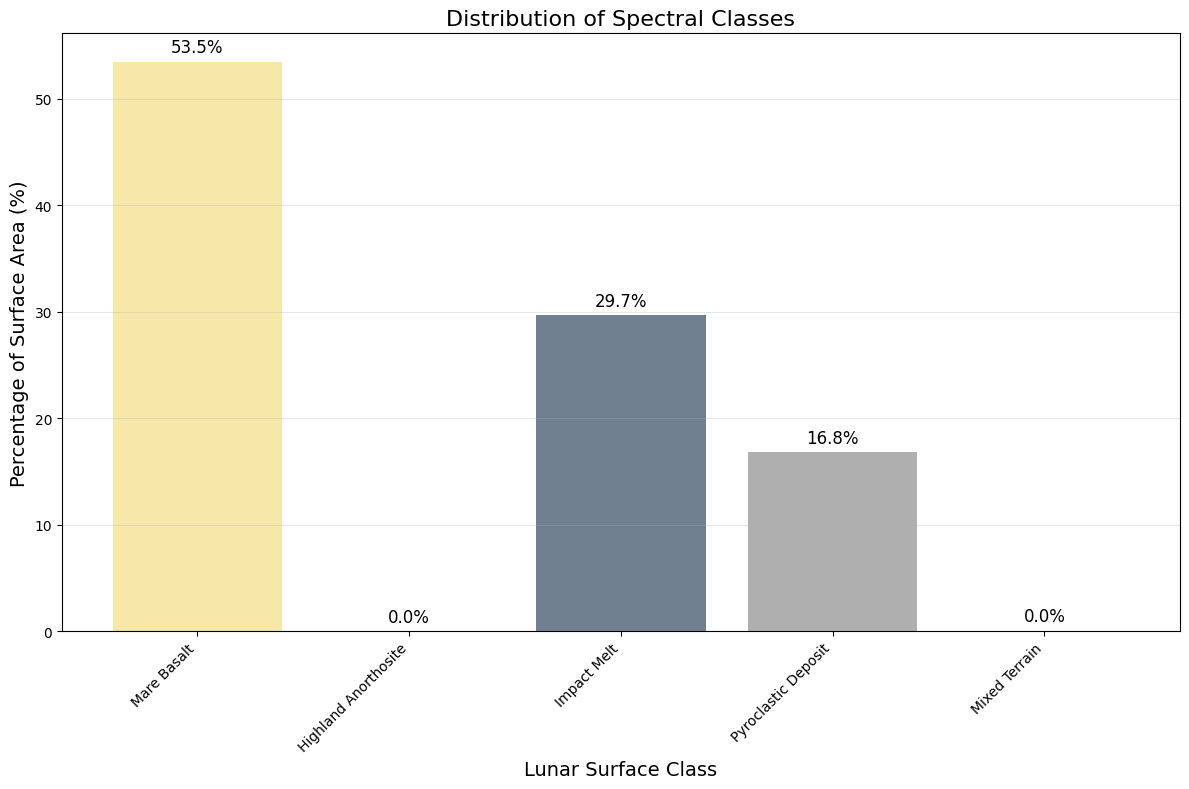

In [137]:
# 6. Visualize class distribution
plt.figure(figsize=(12, 8))
bars = plt.bar(class_names, class_percentages, color=class_colors)
plt.title("Distribution of Spectral Classes", fontsize=16)
plt.xlabel("Lunar Surface Class", fontsize=14)
plt.ylabel("Percentage of Surface Area (%)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', alpha=0.3)

# Add percentage labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
save_fig("class_distribution")
plt.show()

In [138]:
# 7. Scientific interpretation report
print("\n" + "="*80)
print("LUNAR SURFACE COMPOSITION INTERPRETATION")
print("="*80)

class_interpretations = {
    'Mare Basalt': """
    Characteristics: Low albedo (dark appearance), relatively flat spectral signature with absorption features in the 1000nm range.
    Interpretation: These regions likely represent lunar maria - the dark, flat plains formed by ancient volcanic eruptions.
    Mare basalts are rich in iron and magnesium minerals like pyroxene and olivine, which cause the distinctive
    absorption features in the near-infrared wavelengths. These areas formed between 3.1 and 3.9 billion years ago.
    """,

    'Highland Anorthosite': """
    Characteristics: High albedo (bright appearance), relatively steep spectral slope with absorption features around 1250nm.
    Interpretation: These regions represent lunar highlands, which are older and more heavily cratered than maria.
    They are dominated by anorthosite, a rock composed primarily of calcium-rich plagioclase feldspar.
    Highland materials represent the original lunar crust, formed approximately 4.5 billion years ago during lunar magma ocean crystallization.
    """,

    'Impact Melt': """
    Characteristics: Moderate albedo, distinctive absorption features in multiple wavelength bands.
    Interpretation: These areas likely represent impact melt materials - rocks that were melted and then
    re-solidified during meteor impacts. They often contain a mixture of both highland and mare materials,
    with distinctive spectral features resulting from shock metamorphism of minerals.
    """,

    'Pyroclastic Deposit': """
    Characteristics: Moderate to low albedo, relatively smooth spectral signature with specific absorption features.
    Interpretation: These regions likely represent pyroclastic deposits - volcanic ash and glass beads formed during
    explosive "fire fountain" eruptions on the Moon. They often contain volcanic glasses rich in titanium,
    iron, and sometimes sulfur compounds, with distinctive spectral signatures.
    """,

    'Mixed Terrain': """
    Characteristics: Variable albedo, complex spectral signature combining features from multiple classes.
    Interpretation: These areas represent regions with mixed composition, possibly due to ejecta from impacts,
    regolith mixing processes, or areas where mare and highland materials interface. The complex spectral
    signature suggests a heterogeneous surface composition.
    """
}

for class_name, interpretation in class_interpretations.items():
    print(f"\n{class_name}:")
    print(interpretation.strip())

print("\nNote: This interpretation is based on spectral pattern analysis and comparison with known lunar mineralogy.")
print("Ground-truth validation would require sample analysis or correlation with existing lunar sample data.")
print("="*80)


LUNAR SURFACE COMPOSITION INTERPRETATION

Mare Basalt:
Characteristics: Low albedo (dark appearance), relatively flat spectral signature with absorption features in the 1000nm range.
    Interpretation: These regions likely represent lunar maria - the dark, flat plains formed by ancient volcanic eruptions. 
    Mare basalts are rich in iron and magnesium minerals like pyroxene and olivine, which cause the distinctive 
    absorption features in the near-infrared wavelengths. These areas formed between 3.1 and 3.9 billion years ago.

Highland Anorthosite:
Characteristics: High albedo (bright appearance), relatively steep spectral slope with absorption features around 1250nm.
    Interpretation: These regions represent lunar highlands, which are older and more heavily cratered than maria.
    They are dominated by anorthosite, a rock composed primarily of calcium-rich plagioclase feldspar. 
    Highland materials represent the original lunar crust, formed approximately 4.5 billion years